# Prepare Universal Dependencies Treebank Dataset & Preprocessing

We are using the UD English EWT Treebank for our dataset. The corpus comprises 254,820 words and 16,622 sentences, taken from five genres of web media: weblogs, newsgroups, emails, reviews, and Yahoo! answers. HuggingFace has these datasets ready to load using the datasets module.

Documentation for the English UD EWT treebank: https://universaldependencies.org/treebanks/en_ewt/index.html

Important note: Taking a look at the tokens list (for a sentence), it's 1-based indexing because of UD indexing. This is because index 0 refers to the root, so index 1 refers to the first token of the sentence.

In [30]:
''' Install necessary libraries '''

!pip install datasets
!pip install conllu

In [2]:
''' The UD treebank is available on Hugging Face via the datasets library '''

from datasets import load_dataset

# Loading dataset parameters
treebank_name = "en_ewt"
split=None  # Load all three splits: train, test, & validation sets.

# Load UD Treebank
dataset = load_dataset("universal_dependencies", treebank_name, split=split)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/191k [00:00<?, ?B/s]

universal_dependencies.py:   0%|          | 0.00/87.8k [00:00<?, ?B/s]

The repository for universal_dependencies contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/universal_dependencies.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/12543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2002 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2077 [00:00<?, ? examples/s]

In [31]:
''' Preprocessing for subject-verb pairs '''

import ast
from typing import Tuple

def get_dep_info(dep_str: str) -> Tuple[str, int]:
    """
    Convert dependency string representation to tuple

    Args:
      dep_str: A string representation of the dependency list in the format of "[('dependency', head_index)]".

    Returns:
      A tuple containing the dependency relation and the head index.
    """

    try:
        dep_list = ast.literal_eval(dep_str)  # Convert the string representation to a list of tuple
        if dep_list:
            return dep_list[0]  # dep_list has structure [(dependency, head_index)], and we're interested in the dependency tuple in dep_list.
        return ('N/A', 0)
    except:
        return ('N/A', 0)

def extract_subject_verb_pairs(sentence: dict) -> list[dict]:
    """
    Extract subject-verb pairs from a sentence.

    Args:
      sentence: A sample sentence from the UD treebank. The UD treebank sample includes many keys, but we're only interested in the deps and tokens keys.

    Returns:
      A list of dictionaries containing all the subject-verb pairs in the sentence, and their indices.
    """

    subject_verb_pairs = []
    for i, dep_str in enumerate(sentence['deps']):
        dep_rel, head = get_dep_info(dep_str)
        if dep_rel == 'nsubj' and head > 0: # Skip when the head points to the root.
            subject_idx = i
            verb_idx = head - 1 # The tokens list uses 1-based indexing, because index 0 is technically the root. That's why we're taking the head index - 1, so we can adjust for the 1-based indexing.

            subject_verb_pairs.append({
                'subject': sentence['tokens'][subject_idx],
                'verb': sentence['tokens'][verb_idx],
                'subject_idx': subject_idx,
                'verb_idx': verb_idx
            })

    return subject_verb_pairs

In [63]:
# Test extract_subject_verb_pairs for evaluation
sentence = dataset["train"][45]
# subject_verb_pairs_ex = extract_subject_verb_pairs(sentence)
# print(subject_verb_pairs_ex)
print(' '.join(sentence['tokens']))

Yesterday there were tens of them putting road blocks on our street and setting up mortars , they only come out in the open when Americans leave the area , then they start firing mortars indiscriminately and shooting their AK - 47's in the air .


# Load model from Hugging Face

One thing to keep in mind. BERT uses the WordPiece tokenization scheme, which is different than the UD tokenization scheme. Therefore, we need to map BERT's tokenization scheme to the UD scheme so we can properly do evaluation of BERT on the ground truth subject-verb pairs from the UD dataset.

In [64]:
''' Load the model (in this case, BERT-base-cased) from Hugging Face '''

from transformers import AutoModel, AutoTokenizer

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
model = AutoModel.from_pretrained('bert-base-cased')

The code below takes one sentence from the UD dataset and extracts the subject-verb pair from that sentence. Then, it feeds the sentence into BERT so we can perform analysis. Here, we examine the attention weights from layer 7. Since the BERT tokenization scheme breaks words into subwords, we evaluate the BERT tokens by taking the max attention score across all subwords for a particular word. For example, max(attention score of ['run', '##ning']).

In [32]:
# ''' Load the model (GPT-2) from Hugging Face '''
# from transformers import AutoModel, AutoTokenizer

# model = AutoModel.from_pretrained("gpt2", output_attentions=True)
# tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [33]:
import torch
from typing import List, Tuple

def get_bert_token_mapping(ud_tokens: list, bert_tokens: list, offset_mapping: list) -> dict:
    """
    Create mapping between UD tokens and BERT tokens.

    Args:
      ud_tokens: The tokenized sentence based on the UD treebank tokenizer
      bert_tokens: The tokenized sentence based on the BERT tokenizer
      offset_mapping: The offset mapping from the BERT tokenizer

    Returns:
      A dictionary mapping UD token indices to BERT token indices.
    """

    # Remove special tokens
    bert_tokens = bert_tokens[1:-1]  # Remove [CLS] and [SEP]
    offset_mapping = offset_mapping[1:-1]  # Remove special tokens' offsets, truncating the mapping for the first element [CLS] and last element [SEP].

    # Get our original text. The UD tokenizer splits by whitespace, so recover the full text by joining with a whitespace.
    text = ' '.join(ud_tokens)

    # Create mapping from UD index to BERT token indices
    ud_to_bert = {}
    current_ud_idx = 0
    current_char_idx = 0

    # For each UD token, find all BERT tokens that correspond to it
    for ud_idx, ud_token in enumerate(ud_tokens):
        bert_indices = []
        token_start = text.find(ud_token, current_char_idx)
        token_end = token_start + len(ud_token)

        # Find all BERT tokens that overlap with this UD token
        for bert_idx, (start, end) in enumerate(offset_mapping):
            # Check if this BERT token overlaps with current UD token
            if start >= token_start and end <= token_end:
                bert_indices.append(bert_idx + 1) # +1 to account for [CLS] token

        ud_to_bert[ud_idx] = bert_indices
        current_char_idx = token_end

    return ud_to_bert

def create_gpt2_offset_mapping(text: str, tokenizer: GPT2Tokenizer) -> List[Tuple[int, int]]:
    """
    Creates offset mappings for GPT-2 tokens similar to other transformers tokenizers.

    Args:
        text: Input text string
        tokenizer: GPT2Tokenizer instance

    Returns:
        List of tuples containing (start, end) character positions for each token
    """
    tokens = tokenizer.tokenize(text)
    offset_mapping = []

    current_pos = 0
    for token in tokens:
        # Handle special space token at start of word
        if token.startswith('Ġ'):
            # Skip the space character in position tracking
            current_pos += 1
            token = token[1:]

        # Find the token in the text starting from current_pos
        token_start = text.find(token, current_pos)
        if token_start == -1:
            # Handle cases where the exact token isn't found
            # (e.g., due to special characters or tokenizer quirks)
            token_start = current_pos

        token_end = token_start + len(token)
        offset_mapping.append((token_start, token_end))
        current_pos = token_end

    return offset_mapping

def get_gpt2_token_mapping(ud_tokens: list, gpt2_tokens: list, offset_mapping: List[Tuple[int, int]]) -> dict:
    """
    Create mapping between UD tokens and GPT-2 tokens.

    Args:
      ud_tokens: The tokenized sentence based on the UD treebank tokenizer
      gpt2_tokens: The tokenized sentence based on the GPT-2 tokenizer
      offset_mapping: The offset mapping from the GPT-2 tokenizer

    Returns:
      A dictionary mapping UD token indices to GPT-2 token indices.
    """

    # Get our original text. The UD tokenizer splits by whitespace, so recover the full text by joining with a whitespace.
    text = ' '.join(ud_tokens)

    # Create mapping from UD index to GPT-2 token indices
    ud_to_gpt2 = {}
    current_ud_idx = 0
    current_char_idx = 0

    # For each UD token, find all BERT tokens that correspond to it
    for ud_idx, ud_token in enumerate(ud_tokens):
        gpt2_indices = []
        token_start = text.find(ud_token, current_char_idx)
        token_end = token_start + len(ud_token)

        # Find all GPT-2 tokens that overlap with this UD token. Note that GPT-2 tokens start with a 'Ġ'
        for gpt2_idx, (start, end) in enumerate(offset_mapping):
          # Check if GPT-2 token overlaps with current UD token
          if start >= token_start and end <= token_end:
            gpt2_indices.append(gpt2_idx)

        ud_to_gpt2[ud_idx] = gpt2_indices
        current_char_idx = token_end

    return ud_to_gpt2

# Experiment 1 (Not included in report): For one sentence, probe all the layers and head for their attention scores for the subject-verb dependencies within that one sentence

In [29]:
# ''' Experiment setup to see how subject-verb pairs within a certain sentence are scored for attention heads at a specified layer. '''

# # Get a sentence with subject-verb pairs
# sentence = dataset['train'][0]  # Change index to get different sentence samples
# text = ' '.join(sentence['tokens'])
# pairs = extract_subject_verb_pairs(sentence)

# print(f"Sentence: {text}")
# print(f"Subject-verb pairs: {pairs}")

# # Tokenize with BERT
# encoding = tokenizer(text, return_tensors='pt', return_offsets_mapping=True)
# input_ids = encoding['input_ids']
# offset_mapping = encoding['offset_mapping'][0].numpy()  # Remove batch dimension
# bert_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# print(offset_mapping)

# # Get token mapping
# token_mapping = get_bert_token_mapping(sentence['tokens'], bert_tokens, offset_mapping)

# print("\nBERT tokenization:", bert_tokens)
# print("\nToken mapping:")
# for ud_idx, bert_indices in token_mapping.items():
#     print(f"UD token '{sentence['tokens'][ud_idx]}' -> BERT tokens: {[bert_tokens[i] for i in bert_indices]}")

# # Get attention weights
# with torch.no_grad():
#     outputs = model(input_ids, output_attentions=True)

# # Get attention scores for every head on every layer, so 12*12=144 attention scores in total
# attention_scores_at_each_layer = []
# for layer_idx in range(len(outputs.attentions)):
#   attention = outputs.attentions[layer_idx][0]  # Shape: [num_heads, seq_len, seq_len]
#   # For each attention head, there is a seq_len x seq_len matrix of attention scores.
#   # The rows are tokens DOING the attending; query
#   # The columns are tokens BEING attended to; key
#   # Each cell [i,j] shows how much token i pays attention to token j
#   # We are trying to find the scores for the row subject token (query) and column verb token (key)

#   # Analyze attention for subject-verb pairs with proper token mapping
#   print(f"\nAttention analysis for layer {layer_idx}:")
#   for pair in pairs:
#       subject_bert_indices = token_mapping[pair['subject_idx']]
#       verb_bert_indices = token_mapping[pair['verb_idx']]

#       print(f"\nPair: {pair['subject']} -> {pair['verb']}")
#       print(f"BERT tokens: {[bert_tokens[i] for i in subject_bert_indices]} -> {[bert_tokens[i] for i in verb_bert_indices]}")

#       # For each attention head
#       curr_layer_head = []
#       for head in range(attention.size(0)):
#           # Get max attention scores across all subword combinations
#           scores = []
#           for subj_idx in subject_bert_indices:
#               for verb_idx in verb_bert_indices:
#                   scores.append(attention[head, subj_idx, verb_idx].item()) # Asking: In this attention head, how much does the token at subject_idx attend to the token at verb_idx?
#           # print(scores)
#           max_score = max(scores) # There can be multiple scores in the attention matrix corresponding to one word (either subject or the verb) because of how the tokenizer breaks up those words. So we take the max of the scores.

#           print(f"Head {head}: {max_score:.3f}")
#           curr_layer_head.append(max_score)

#   attention_scores_at_each_layer.append(curr_layer_head)


# Experiment 2: Extract the mean attention scores for subject-verb dependencies given 200 samples and plot as a heatmap

Processed 200 pairs:   1%|          | 155/12543 [00:10<14:30, 14.23it/s]


Total subject-verb pairs processed: 200


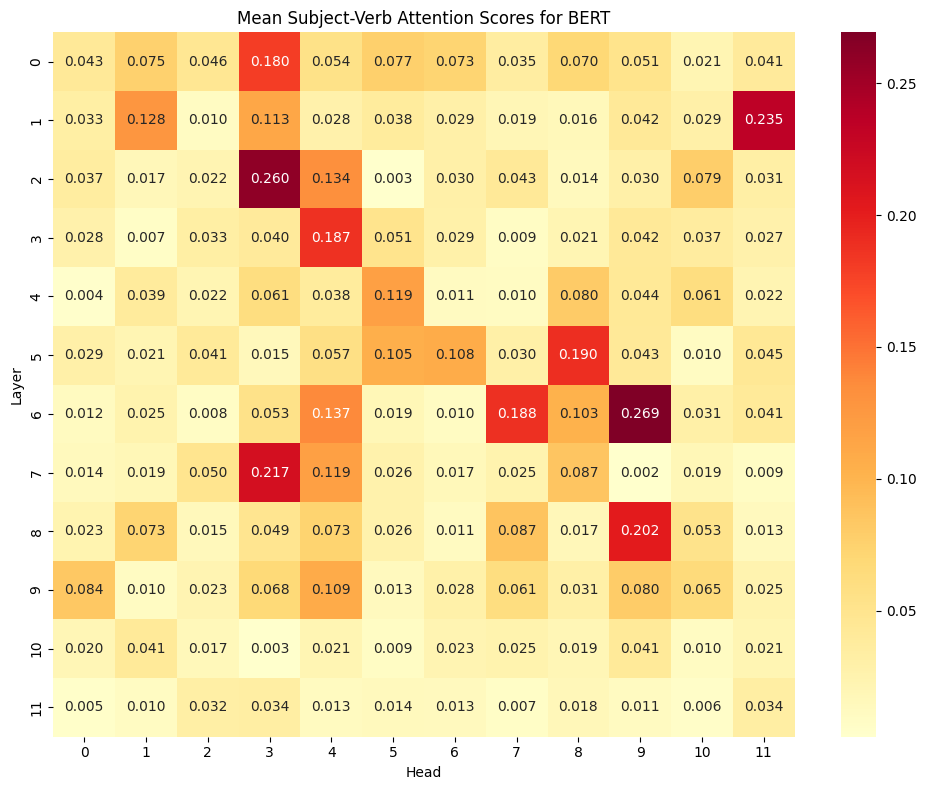

In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

def analyze_attention_patterns(dataset: dict[str, list], model: AutoModel, tokenizer: AutoTokenizer, num_samples: int=200) -> np.ndarray:
    """
    Analyze attention patterns for subject-verb pairs.

    Args:
      dataset: The dataset in UD treebank format.
      model: The model.
      tokenizer: The tokenizer.
      num_samples: Number of subject-verb pair samples (not full sentences) to analyze.

    Returns:
      A matrix of the mean attention scores for each head in each layer for all subject-verb pairs.
    """

    device = next(model.parameters()).device

    # Initialize matrix for means
    subj_verb_scores = np.zeros((12, 12))  # Matrix of [layers, heads]
    pair_count = 0

    # Process dataset
    pbar = tqdm(dataset['train']) # Loading bar
    for sentence in pbar:
        if pair_count >= num_samples:
            break

        text = ' '.join(sentence['tokens'])

        # Tokenize with BERT
        encoding = tokenizer(text, return_tensors='pt', return_offsets_mapping=True)
        input_ids = encoding['input_ids'].to(device)

        # This is a really hacky solution. Originally, this function was written just for BERT but we're extending this to GPT-2 which is a bit different.
        # The offset_mapping line will throw an error for the GPT-2 model.
        try:
          ''' For BERT '''
          offset_mapping = encoding['offset_mapping'][0].cpu().numpy()
          bert_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
          # Get token mapping
          token_mapping = get_bert_token_mapping(sentence['tokens'], bert_tokens, offset_mapping)

        except:
          ''' For GPT-2 '''
          offset_mapping = create_gpt2_offset_mapping(text, tokenizer)
          token_mapping = get_gpt2_token_mapping(sentence['tokens'], offset_mapping, tokenizer)

        # Get attention weights for all layers
        with torch.no_grad():
            outputs = model(input_ids, output_attentions=True)

        # Extract subject-verb pairs
        pairs = extract_subject_verb_pairs(sentence)

        for pair in pairs:
            token1_indices = token_mapping[pair['subject_idx']]
            token2_indices = token_mapping[pair['verb_idx']]

            if not token1_indices or not token2_indices:
                continue

            # Increment pair count once per valid pair
            pair_count += 1
            pbar.set_description(f"Processed {pair_count} pairs")

            # For each layer
            for layer_idx, layer_attention in enumerate(outputs.attentions):
                attention = layer_attention[0].cpu()

                # For each head in the layer
                for head_idx in range(attention.size(0)):
                    # Get max attention score for this pair
                    scores = []
                    for idx1 in token1_indices:
                        for idx2 in token2_indices:
                            scores.append(attention[head_idx, idx1, idx2].item())

                    if scores:
                        max_score = max(scores)
                        subj_verb_scores[layer_idx, head_idx] += max_score

    print(f"Total subject-verb pairs processed: {pair_count}")

    # Calculate means
    subj_verb_means = subj_verb_scores / pair_count

    return subj_verb_means

def plot_attention_analysis(attention_scores: np.ndarray, title_text: str=""):
    """
    Create heatmap showing the mean attention scores.

    Args:
      attention_scores: A matrix of the mean attention scores for each head in each layer for all subject-verb pairs.
      title_text: Additional text to add to the title of the heatmap.

    Returns:
      Plots a heatmap showing the mean attention scores.
    """

    plt.figure(figsize=(10, 8))

    # Create DataFrame for seaborn
    df = pd.DataFrame(attention_scores)
    df.index.name = 'Layer'
    df.columns.name = 'Head'

    # Plot means for subject-verb pairs
    sns.heatmap(df, annot=True, fmt='.3f', cmap='YlOrRd')
    plt.title(f'Mean Subject-Verb Attention Scores {title_text}')
    plt.tight_layout()
    plt.show()

# Run the analysis
results = analyze_attention_patterns(dataset, model, tokenizer)
plot_attention_analysis(results, title_text="for BERT")

100%|██████████| 5/5 [00:00<00:00, 30.06it/s]
<ipython-input-36-b6cbdf6cc10f>:91: RuntimeWarning: invalid value encountered in divide
  subj_verb_means = subj_verb_scores / pair_count
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Total subject-verb pairs processed: 0


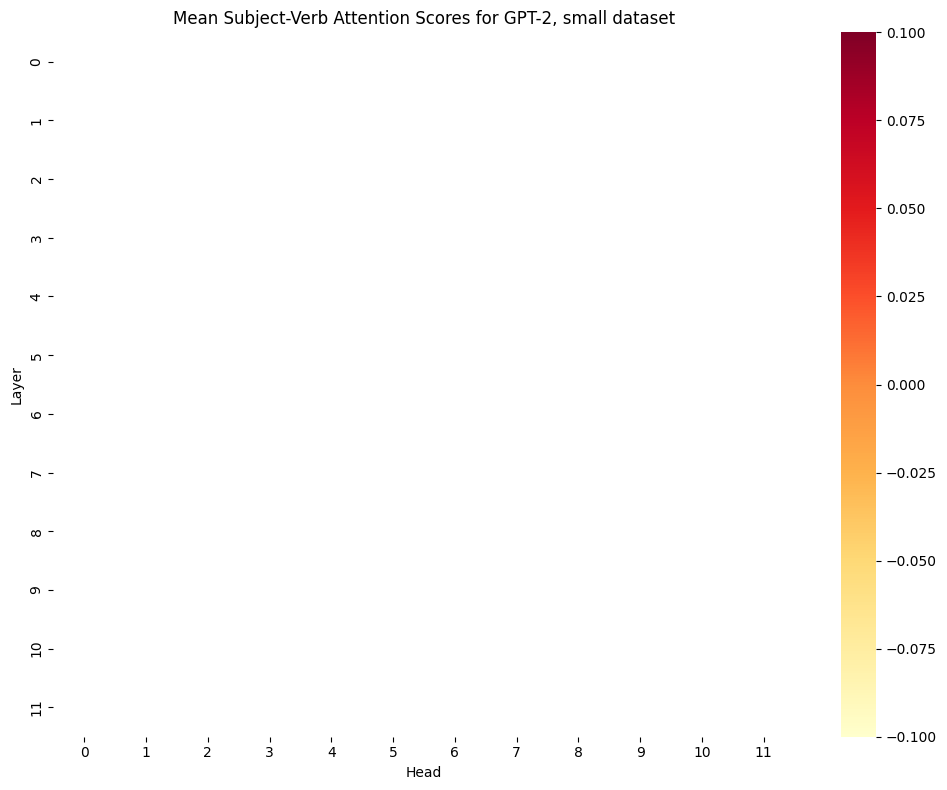

In [40]:
# A small 5 sample dataset of sentences we found online that has subject-verb depencies. We use it for a quantitative analysis (mean heatmap) to align with our qualitative analysis discussion.
# Each sample includes a text and the indices of the subject-verb pairs (according UD indexing)
custom_sentences = [
    {
        'text': "Bob is running a company.",
        'pairs': [(0, 2)]  # Subject: Bob (index 0) & Verb: running (index 2)
    },
    {
        'text': "I like to verb verbs",
        'pairs': [(0, 1)]  # Subject: I (index 0) & Verb: like (index 1)
    },
    {
        'text': "Time flies when you're having fun",
        'pairs': [(0, 1), (3, 4)]  # Subject: Time (index 0) & Verb: flies (index 1); Subject: you (index 3) & Verb: having (index 4)
    },
    {
        'text': "The truth will set you free",
        'pairs': [(1, 3)]  # Subject: truth (index 1) & Verb: set (index 3)
    },
    {
        'text': "You have the right to make a right turn",
        'pairs': [(0, 1)]  # Subject: You (index 0) & Verb: have (index 1)
    }
]

# Create a new custom dataset in the format of the UD treebank
dataset2 = []
for sentence_data in custom_sentences:
    # Tokenize the sentence by splitting at whitespaces, which is how the UD treebank does it.
    tokens = sentence_data['text'].split()

    # Initialize deps as an unlabeled depedency list
    deps = ['[("N/A", 0)]' for _ in tokens]

    # Add subject-verb dependencies into deps, that's the only thing we're looking for
    for subj_idx, verb_idx in sentence_data['pairs']:
        deps[subj_idx] = f'[("nsubj", {verb_idx + 1})]' # verb_idx+1 because the UD treebank uses 1-based indexing

    dataset2.append({
        'tokens': tokens,
        'deps': deps
    })

# Dict structure similar to original dataset, so we access the 'train' set using dataset2['train']
dataset2 = {'train': dataset2}

# dataset2 is prepared to be used
results2 = analyze_attention_patterns(dataset2, model, tokenizer, num_samples=5)
plot_attention_analysis(results2, title_text="for GPT-2, small dataset")

In [43]:
results2

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

# Experiment 3: POS Tag replacement for the verb in the subject-verb pairs to verify if the attention pattern holds

## Replacing verb with another verb

Processed 5 pairs:  80%|████████  | 4/5 [00:00<00:00, 23.99it/s]


Total subject-verb pairs processed: 5


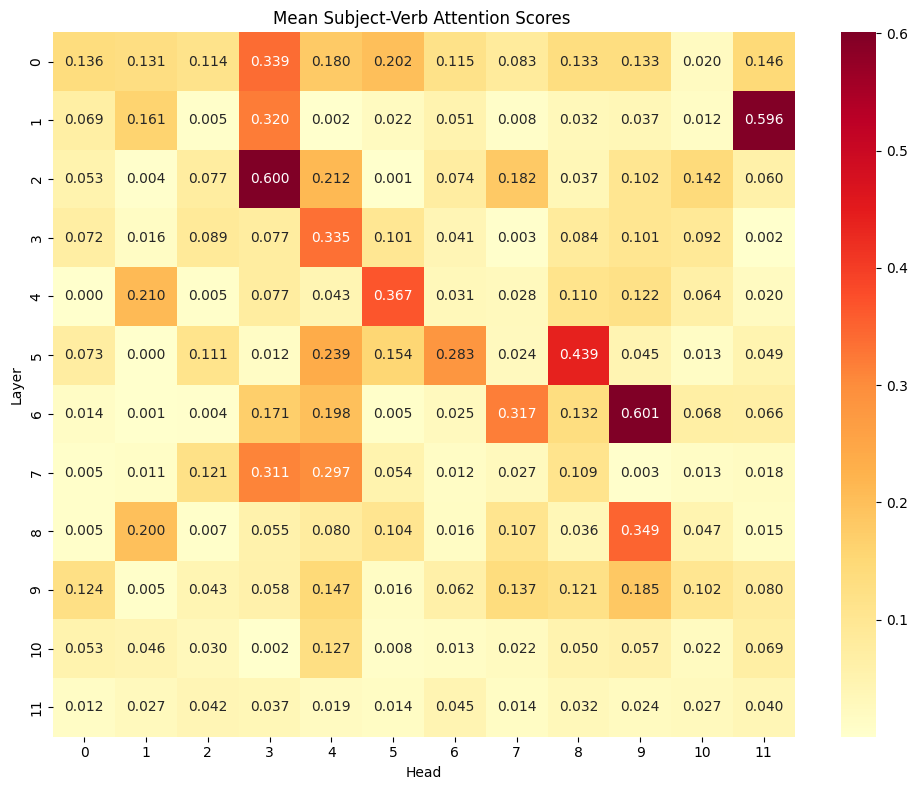

In [22]:
''' Replace verbs in custom sentence with another verb to verify subject-verb dependency. '''
custom_sentences_verb_replacement_verb = [
    {
        'text': "Bob is heading a company.",
        'pairs': [(0, 2)]  # Subject: Bob (index 0) & Verb: heading (index 2)
    },
    {
        'text': "I have to verb verbs",
        'pairs': [(0, 1)]  # Subject: I (index 0) & Verb: have (index 1)
    },
    {
        'text': "Time runs when you're seeking fun",
        'pairs': [(0, 1), (3, 4)]  # Subject: Time (index 0) & Verb: runs (index 1); Subject: you (index 3) & Verb: seeking (index 4)
    },
    {
        'text': "The truth will let you free",
        'pairs': [(1, 3)]  # Subject: truth (index 1) & Verb: let (index 3)
    },
    {
        'text': "You need the right to make a right turn",
        'pairs': [(0, 1)]  # Subject: You (index 0) & Verb: need (index 1)
    }
]

# Create a new custom dataset in the format of the UD treebank
dataset2_verb_replaced_with_verb = []
for sentence_data in custom_sentences_verb_replacement_verb:
    # Tokenize the sentence by splitting at whitespaces, which is how the UD treebank does it.
    tokens = sentence_data['text'].split()

    # Initialize deps as an unlabeled depedency list
    deps = ['[("N/A", 0)]' for _ in tokens]

    # Add subject-verb dependencies into deps, that's the only thing we're looking for
    for subj_idx, verb_idx in sentence_data['pairs']:
        deps[subj_idx] = f'[("nsubj", {verb_idx + 1})]' # verb_idx+1 because the UD treebank uses 1-based indexing

    dataset2_verb_replaced_with_verb.append({
        'tokens': tokens,
        'deps': deps
    })

# Dict structure similar to original dataset, so we access the 'train' set using dataset2_verb_replaced_with_verb['train']
dataset2_verb_replaced_with_verb = {'train': dataset2_verb_replaced_with_verb}

# dataset2_verb_replaced_with_verb is prepared to be used
results2_verb_replaced_with_verb = analyze_attention_patterns(dataset2_verb_replaced_with_verb, model, tokenizer, num_samples=5)
plot_attention_analysis(results2_verb_replaced_with_verb)

## Replacing verb with another noun

Processed 5 pairs:  80%|████████  | 4/5 [00:00<00:00, 22.42it/s]


Total subject-verb pairs processed: 5


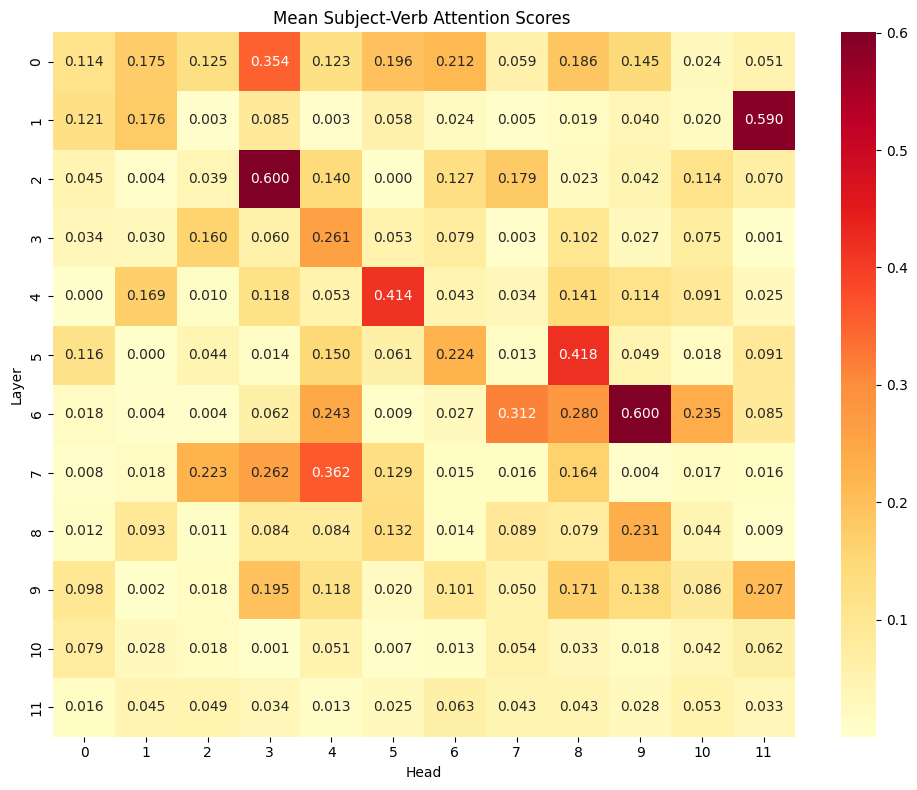

In [23]:
''' Replace verbs in custom sentence with a noun to see if the usual subject-verb dependency trend dissapears '''

custom_sentences_verb_replacement_noun = [
    {
        'text': "Bob is car a company.",
        'pairs': [(0, 2)]  # Subject: Bob (index 0) & Noun: car (index 2)
    },
    {
        'text': "I bee to verb verbs",
        'pairs': [(0, 1)]  # Subject: I (index 0) & Noun: bee (index 1)
    },
    {
        'text': "Time panda when you're koala fun",
        'pairs': [(0, 1), (3, 4)]  # Subject: Time (index 0) & Noun: panda (index 1); Subject: you (index 3) & Noun: koala (index 4)
    },
    {
        'text': "The truth will pencil you free",
        'pairs': [(1, 3)]  # Subject: truth (index 1) & Noun: pencil (index 3)
    },
    {
        'text': "You computer the right to make a right turn",
        'pairs': [(0, 1)]  # Subject: You (index 0) & Noun: computer (index 1)
    }
]

# Create a new custom dataset in the format of the UD treebank
dataset2_verb_replaced_with_noun = []
for sentence_data in custom_sentences_verb_replacement_noun:
    # Tokenize the sentence by splitting at whitespaces, which is how the UD treebank does it.
    tokens = sentence_data['text'].split()

    # Initialize deps as an unlabeled depedency list
    deps = ['[("N/A", 0)]' for _ in tokens]

    # Add subject-verb dependencies into deps, that's the only thing we're looking for
    for subj_idx, verb_idx in sentence_data['pairs']:
        deps[subj_idx] = f'[("nsubj", {verb_idx + 1})]' # verb_idx+1 because the UD treebank uses 1-based indexing

    dataset2_verb_replaced_with_noun.append({
        'tokens': tokens,
        'deps': deps
    })

# Dict structure similar to original dataset, so we access the 'train' set using dataset2_verb_replaced_with_noun['train']
dataset2_verb_replaced_with_noun = {'train': dataset2_verb_replaced_with_noun}

# dataset2_verb_replaced_with_noun is prepared to be used
results2_verb_replaced_with_noun = analyze_attention_patterns(dataset2_verb_replaced_with_noun, model, tokenizer, num_samples=5)
plot_attention_analysis(results2_verb_replaced_with_noun)

## Replacing verb with another adjective


Processed 5 pairs:  80%|████████  | 4/5 [00:00<00:00, 29.03it/s]


Total subject-verb pairs processed: 5


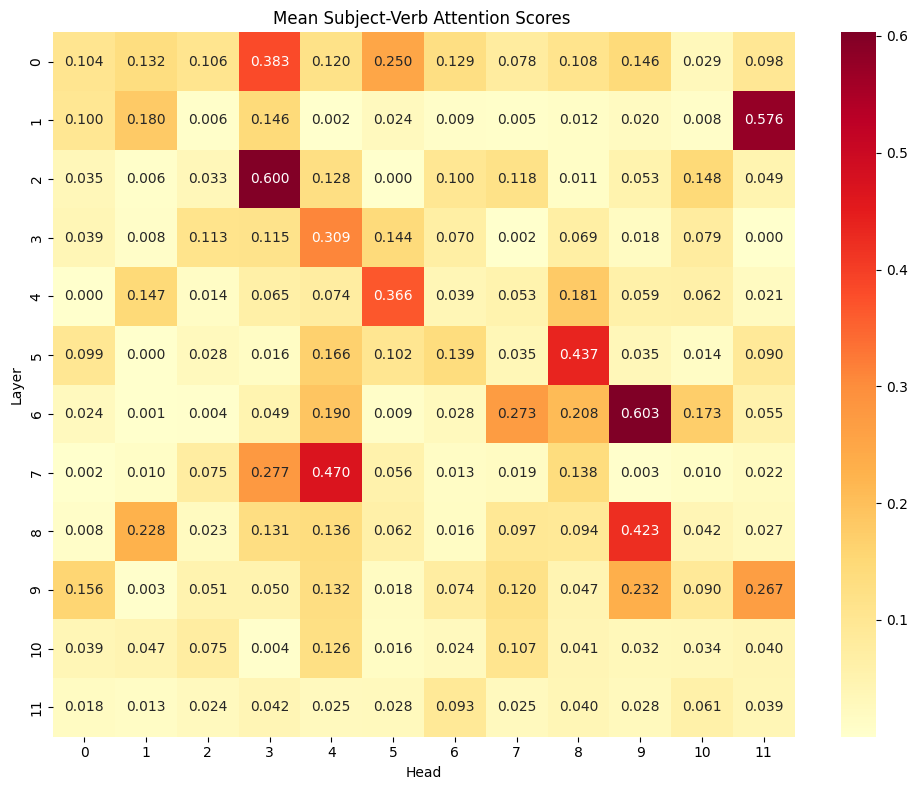

In [24]:
''' Replace verbs with adjective '''

custom_sentences_verb_replacement_adj = [
    {
        'text': "Bob is happy a company.",
        'pairs': [(0, 2)]  # Subject: Bob (index 0) & Adjective: running (index 2)
    },
    {
        'text': "I tall to verb verbs",
        'pairs': [(0, 1)]  # Subject: I (index 0) & Adjective: tall (index 1)
    },
    {
        'text': "Time blue when you're bright fun",
        'pairs': [(0, 1), (3, 4)]  # Subject: Time (index 0) & Adjective: blue (index 1); Subject: you (index 3) & Adjective: bright (index 4)
    },
    {
        'text': "The truth will small you free",
        'pairs': [(1, 3)]  # Subject: truth (index 1) & Adjective: small (index 3)
    },
    {
        'text': "You quick the right to make a right turn",
        'pairs': [(0, 1)]  # Subject: You (index 0) & Adjective: quick (index 1)
    }
]

# Create a new custom dataset in the format of the UD treebank
dataset2_verb_replaced_with_adj = []
for sentence_data in custom_sentences_verb_replacement_adj:
    # Tokenize the sentence by splitting at whitespaces, which is how the UD treebank does it.
    tokens = sentence_data['text'].split()

    # Initialize deps as an unlabeled depedency list
    deps = ['[("N/A", 0)]' for _ in tokens]

    # Add subject-verb dependencies into deps, that's the only thing we're looking for
    for subj_idx, verb_idx in sentence_data['pairs']:
        deps[subj_idx] = f'[("nsubj", {verb_idx + 1})]' # verb_idx+1 because the UD treebank uses 1-based indexing

    dataset2_verb_replaced_with_adj.append({
        'tokens': tokens,
        'deps': deps
    })

# Dict structure similar to original dataset, so we access the 'train' set using dataset2_verb_replaced_with_adj['train']
dataset2_verb_replaced_with_adj = {'train': dataset2_verb_replaced_with_adj}

# dataset2_verb_replaced_with_adj is prepared to be used
results2_verb_replaced_with_adj = analyze_attention_patterns(dataset2_verb_replaced_with_adj, model, tokenizer, num_samples=5)
plot_attention_analysis(results2_verb_replaced_with_adj)

## Replace verbs with prepositions

Processed 5 pairs:  80%|████████  | 4/5 [00:00<00:00, 27.31it/s]


Total subject-verb pairs processed: 5


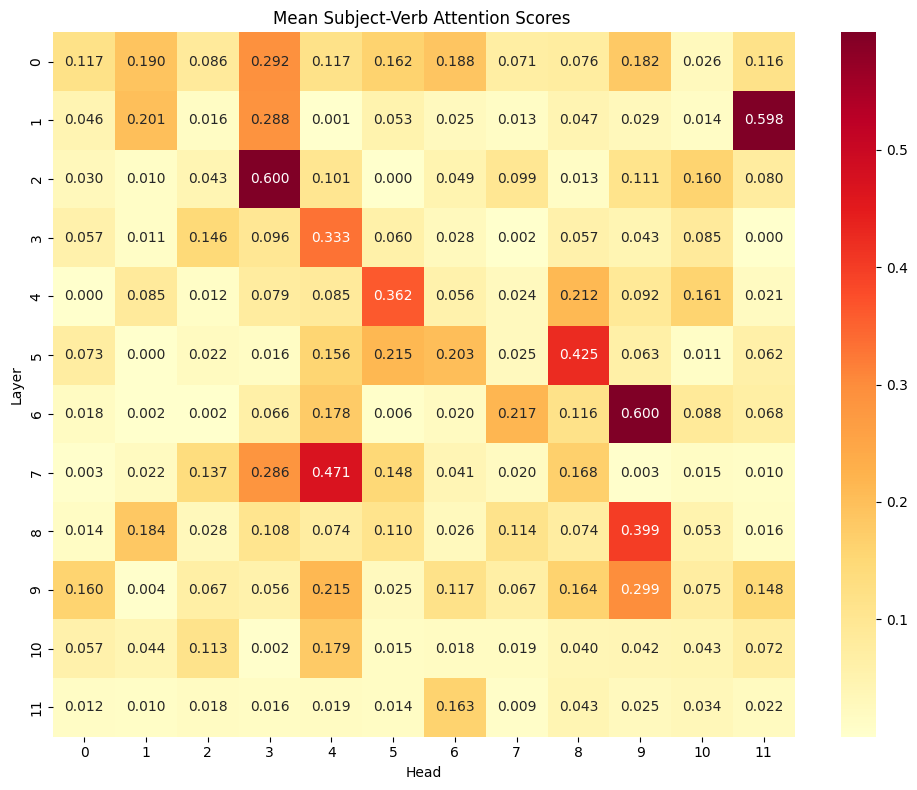

In [25]:
''' Replace verbs with prepositions '''

custom_sentences_verb_replacement_prep = [
    {
        'text': "Bob is under a company.",
        'pairs': [(0, 2)]  # Subject: Bob (index 0) & Prep: under (index 2)
    },
    {
        'text': "I through to verb verbs",
        'pairs': [(0, 1)]  # Subject: I (index 0) & Prep: through (index 1)
    },
    {
        'text': "Time behind when you're above fun",
        'pairs': [(0, 1), (3, 4)]  # Subject: Time (index 0) & Prep: behind (index 1); Subject: you (index 3) & Prep: above (index 4)
    },
    {
        'text': "The truth will inside you free",
        'pairs': [(1, 3)]  # Subject: truth (index 1) & Prep: inside (index 3)
    },
    {
        'text': "You across the right to make a right turn",
        'pairs': [(0, 1)]  # Subject: You (index 0) & Prep: across (index 1)
    }
]

# Create a new custom dataset in the format of the UD treebank
dataset2_verb_replaced_with_prep = []
for sentence_data in custom_sentences_verb_replacement_prep:
    # Tokenize the sentence by splitting at whitespaces, which is how the UD treebank does it.
    tokens = sentence_data['text'].split()

    # Initialize deps as an unlabeled depedency list
    deps = ['[("N/A", 0)]' for _ in tokens]

    # Add subject-verb dependencies into deps, that's the only thing we're looking for
    for subj_idx, verb_idx in sentence_data['pairs']:
        deps[subj_idx] = f'[("nsubj", {verb_idx + 1})]' # verb_idx+1 because the UD treebank uses 1-based indexing

    dataset2_verb_replaced_with_prep.append({
        'tokens': tokens,
        'deps': deps
    })

# Dict structure similar to original dataset, so we access the 'train' set using dataset2_verb_replaced_with_prep['train']
dataset2_verb_replaced_with_prep = {'train': dataset2_verb_replaced_with_prep}

# dataset2_verb_replaced_with_prep is prepared to be used
results2_verb_replaced_with_prep = analyze_attention_patterns(dataset2_verb_replaced_with_prep, model, tokenizer, num_samples=5)
plot_attention_analysis(results2_verb_replaced_with_prep)

## Replace verb with adverbs

Processed 5 pairs:  80%|████████  | 4/5 [00:00<00:00, 23.28it/s]


Total subject-verb pairs processed: 5


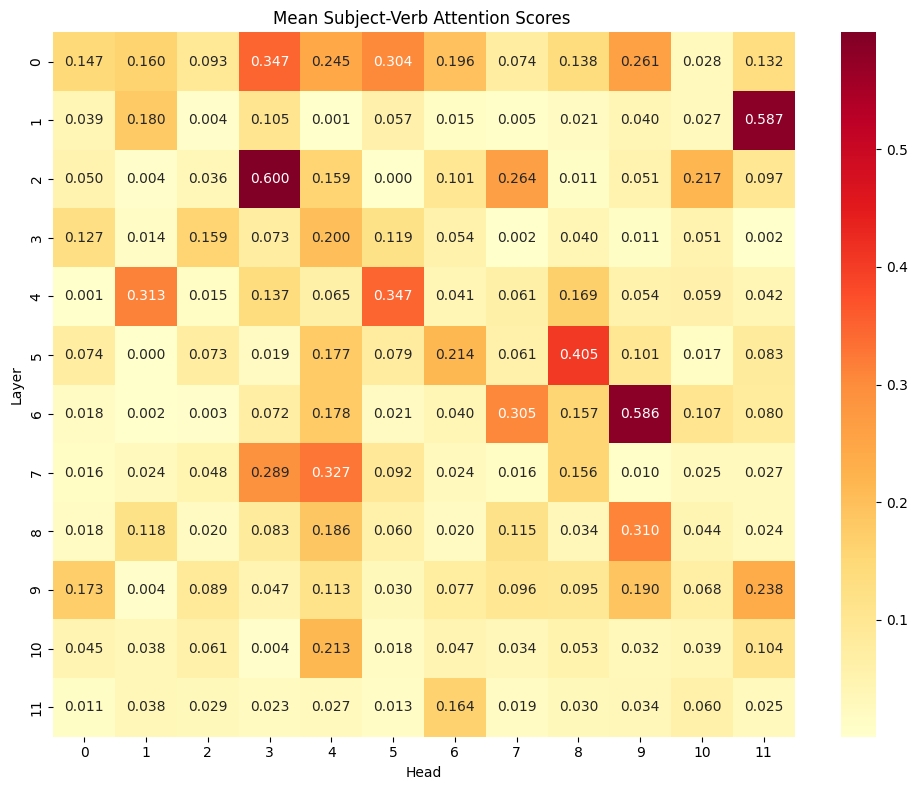

In [26]:
custom_sentences_verb_replacement_adv = [
    {
        'text': "Bob is quickly a company.",
        'pairs': [(0, 2)]  # Subject: Bob (index 0) & Adv: quickly (index 2)
    },
    {
        'text': "I softly to verb verbs",
        'pairs': [(0, 1)]  # Subject: I (index 0) & Adv: softly (index 1)
    },
    {
        'text': "Time slowly when you're gently fun",
        'pairs': [(0, 1), (3, 4)]  # Subject: Time (index 0) & Adv: slowly (index 1); Subject: you (index 3) & Adv: gently (index 4)
    },
    {
        'text': "The truth will carefully you free",
        'pairs': [(1, 3)]  # Subject: truth (index 1) & Adv: carefully (index 3)
    },
    {
        'text': "You quietly the right to make a right turn",
        'pairs': [(0, 1)]  # Subject: You (index 0) & Adv: quietly (index 1)
    }
]

# Create a new custom dataset in the format of the UD treebank
dataset2_verb_replaced_with_adv = []
for sentence_data in custom_sentences_verb_replacement_adv:
    # Tokenize the sentence by splitting at whitespaces, which is how the UD treebank does it.
    tokens = sentence_data['text'].split()

    # Initialize deps as an unlabeled depedency list
    deps = ['[("N/A", 0)]' for _ in tokens]

    # Add subject-verb dependencies into deps, that's the only thing we're looking for
    for subj_idx, verb_idx in sentence_data['pairs']:
        deps[subj_idx] = f'[("nsubj", {verb_idx + 1})]' # verb_idx+1 because the UD treebank uses 1-based indexing

    dataset2_verb_replaced_with_adv.append({
        'tokens': tokens,
        'deps': deps
    })

# Dict structure similar to original dataset, so we access the 'train' set using dataset2_verb_replaced_with_adv['train']
dataset2_verb_replaced_with_adv = {'train': dataset2_verb_replaced_with_adv}

# dataset2_verb_replaced_with_adv is prepared to be used
results2_verb_replaced_with_adv = analyze_attention_patterns(dataset2_verb_replaced_with_adv, model, tokenizer, num_samples=5)
plot_attention_analysis(results2_verb_replaced_with_adv)

## Experiment 4: Sanity Check to see if BERT is

Processed 5 pairs:  80%|████████  | 4/5 [00:00<00:00, 23.27it/s]


Total subject-verb pairs processed: 5


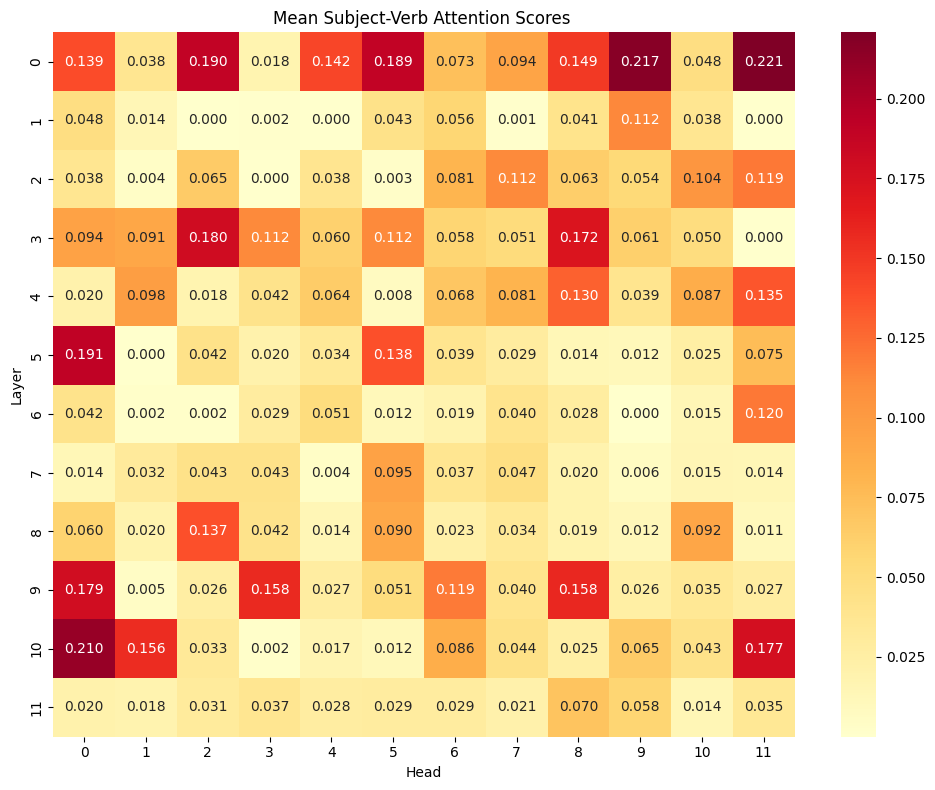

In [71]:
offset = 3
'''
'''


custom_sentences_verb_replacement_adv = [
    {
        'text': "Bob is quickly a company tomorrow.",
        'pairs': [(0, 2 + offset)]  # Subject: Bob (index 0) & Verb: running (index 2)
    },
    {
        'text': "I softly to verb verbs",
        'pairs': [(0, 1 + offset)]  # Subject: I (index 0) & Verb: like (index 1)
    },
    {
        'text': "Time slowly when you're gently fun partying, yeah!",
        'pairs': [(0, 1 + offset), (3, 4 + offset)]  # Subject: Time (index 0) & Verb: flies (index 1); Subject: you (index 3) & Verb: having (index 4)
    },
    {
        'text': "The truth will carefully you free, man",
        'pairs': [(1, 3 + offset)]  # Subject: truth (index 1) & Verb: set (index 3)
    },
    {
        'text': "You quietly the right to make a right turn",
        'pairs': [(0, 1 + offset)]  # Subject: You (index 0) & Verb: have (index 1)
    }
]

# Create a new custom dataset in the format of the UD treebank
dataset2_verb_replaced_with_adv = []
for sentence_data in custom_sentences_verb_replacement_adv:
    # Tokenize the sentence by splitting at whitespaces, which is how the UD treebank does it.
    tokens = sentence_data['text'].split()

    # Initialize deps as an unlabeled depedency list
    deps = ['[("N/A", 0)]' for _ in tokens]

    # Add subject-verb dependencies into deps, that's the only thing we're looking for
    for subj_idx, verb_idx in sentence_data['pairs']:
        deps[subj_idx] = f'[("nsubj", {verb_idx + 1})]' # verb_idx+1 because the UD treebank uses 1-based indexing

    dataset2_verb_replaced_with_adv.append({
        'tokens': tokens,
        'deps': deps
    })

# Dict structure similar to original dataset, so we access the 'train' set using dataset2_verb_replaced_with_adv['train']
dataset2_verb_replaced_with_adv = {'train': dataset2_verb_replaced_with_adv}

# dataset2_verb_replaced_with_adv is prepared to be used
results2_verb_replaced_with_adv = analyze_attention_patterns(dataset2_verb_replaced_with_adv, model, tokenizer, num_samples=5)
plot_attention_analysis(results2_verb_replaced_with_adv)